## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [2]:
from main import *
ari = ARI()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.0+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [3]:
case1, case2 = ari.load_data()

In [4]:
case1_qinv = ari.quadratic_inversion(case1)
case1_inv  = ari.resistivity_inversion(case1)

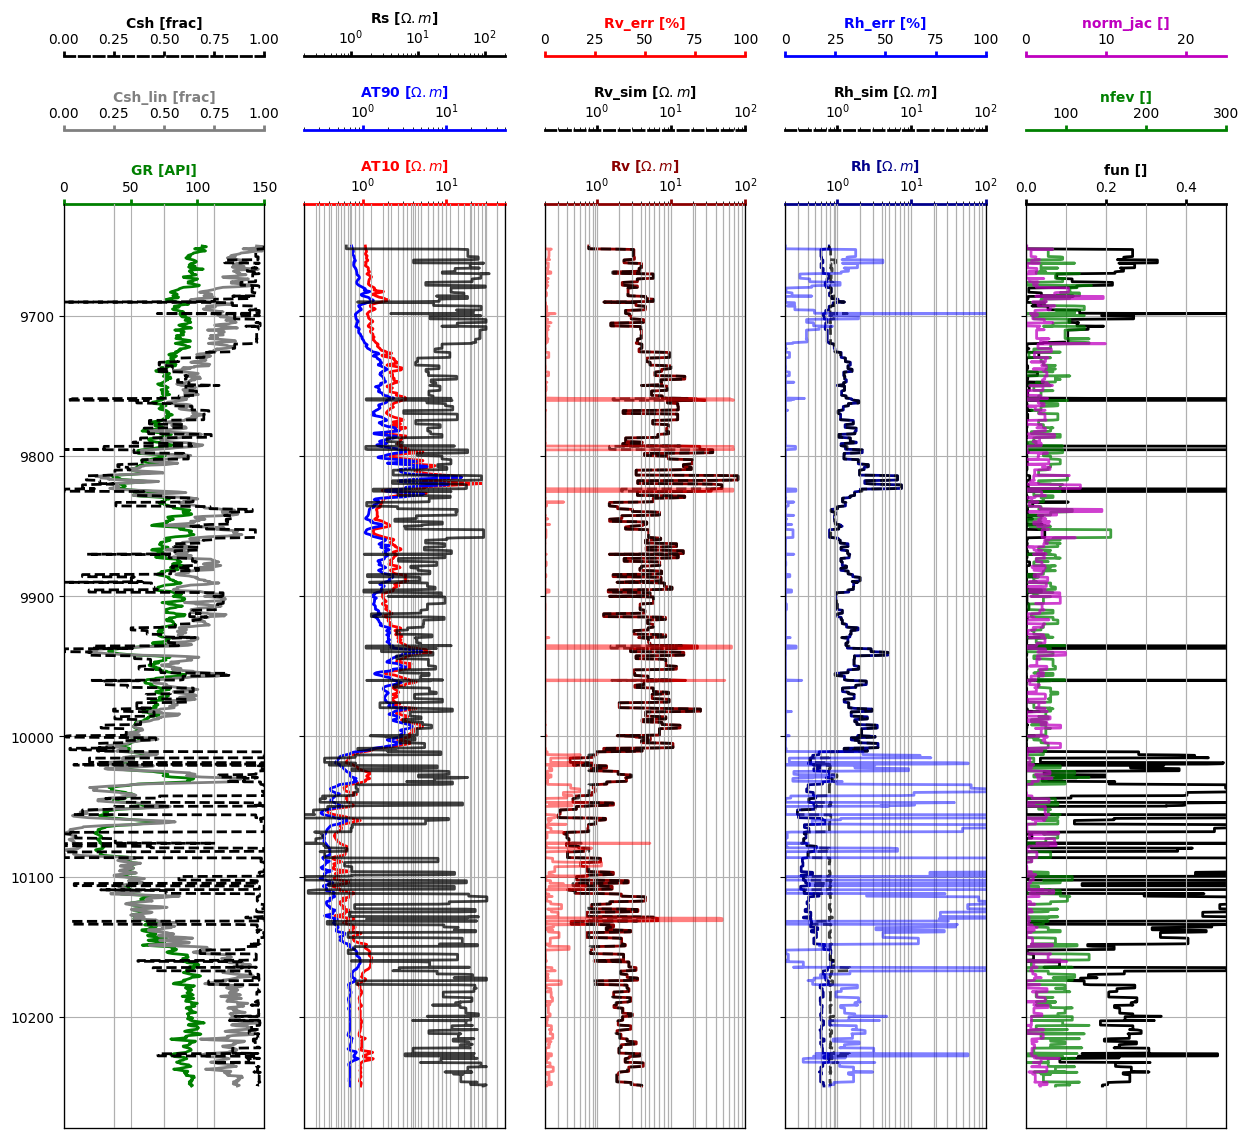

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(15,12), sharey=True, facecolor='white')
ax1, ax2, ax3, ax4, ax5 = axs

ax11, ax12 = ax1.twiny(), ax1.twiny()
ari.plot_curve(ax1,  case1_inv, 'GR',      lb=0, ub=150, color='g',    units='API',  pad=0)
ari.plot_curve(ax11, case1_inv, 'Csh_lin', lb=0, ub=1,   color='gray', units='frac', pad=8)
ari.plot_curve(ax12, case1_inv, 'Csh',     lb=0, ub=1,   color='k',    units='frac', ls='--', pad=16)

ax21, ax22 = ax2.twiny(), ax2.twiny()
ari.plot_curve(ax2,  case1_inv, 'AT10', lb=0.2, ub=50, color='r', units='$\Omega.m$', semilog=True, pad=0)
ari.plot_curve(ax21, case1_inv, 'AT90', lb=0.2, ub=50, color='b', units='$\Omega.m$', semilog=True, pad=8)
ari.plot_curve(ax22, case1_inv, 'Rs',   lb=0.2, ub=200, color='k', units='$\Omega.m$', alpha=0.75, semilog=True, pad=16)

ax31, ax32 = ax3.twiny(), ax3.twiny()
ari.plot_curve(ax3,  case1_inv, 'Rv',     lb=0.2, ub=100, color='darkred',  units='$\Omega.m$',   semilog=True, pad=0)
ari.plot_curve(ax31, case1_inv, 'Rv_sim', lb=0.2, ub=100, color='k', units='$\Omega.m$', ls='--', alpha=0.75, semilog=True, pad=8)
ari.plot_curve(ax32,  case1_inv, 'Rv_err', lb=1e-9, ub=100, color='red', units='%', alpha=0.5, pad=16)

ax41, ax42 = ax4.twiny(), ax4.twiny()
ari.plot_curve(ax4,  case1_inv, 'Rh',     lb=0.2, ub=100, color='darkblue',  units='$\Omega.m$',  semilog=True, pad=0)
ari.plot_curve(ax41, case1_inv, 'Rh_sim', lb=0.2, ub=100, color='k', units='$\Omega.m$', alpha=0.75, ls='--', semilog=True, pad=8)
ari.plot_curve(ax42, case1_inv, 'Rh_err', lb=1e-9, ub=100, color='blue', units='%', alpha=0.5, pad=16)

ax51, ax52 = ax5.twiny(), ax5.twiny()
ari.plot_curve(ax5,  case1_inv, 'fun',      lb=0, ub=0.5,  color='k', pad=0)
ari.plot_curve(ax51, case1_inv, 'nfev',     lb=50, ub=300, color='g', alpha=0.75, pad=8)
ari.plot_curve(ax52, case1_inv, 'norm_jac', lb=0, ub=25,  color='m', alpha=0.75, pad=16)

plt.gca().invert_yaxis()
plt.show()

In [74]:
Rvsh = case1['Rv'].iloc[np.argmax(case1['GR'])]
Rhsh = case1['Rh'].iloc[np.argmax(case1['GR'])]

# Define the loss function
def loss_function(params, Rv, Rh, lambda_reg=1e-6):
    Csh, Rs = params
    res1 = Rv - (Csh*Rvsh + (1-Csh)*Rs)
    res2 = 1/Rh - (Csh/Rvsh + (1-Csh)/Rs)
    return torch.norm(res1)+torch.norm(res2) + lambda_reg*torch.norm(params)

# Define the optimization function
def adinv(row):
    x0 = torch.tensor([0.5, 1.0], requires_grad=True)
    optimizer = torch.optim.Adam([x0], lr=1e-3)
    Rv = torch.tensor(row['Rv'], dtype=torch.float32)
    Rh = torch.tensor(row['Rh'], dtype=torch.float32)
    for _ in range(100):
        optimizer.zero_grad()
        loss = loss_function(x0, Rv, Rh)
        loss.backward()
        optimizer.step()
    return x0.detach().numpy()

# Apply the optimization function to each row
results = case1.apply(adinv, axis=1)
case1[['Csh', 'Rs']] = pd.DataFrame(results.tolist(), index=case1.index)
case1

***
# END